## Evaluate the Simple-English wiki models on Wiki-Viki data

In this notebook, we evaluate the supervised readability models on various test data such as:
- the wiki-viki datasets
- de-klexikon
- ??

Steps:
- load either the gridsearch 

In [1]:
# general parameters
runs = 5
preprocess_flag = True
gridsearch_flag = True
lede_flag = True

if preprocess_flag:
    preprocessed = 'standardized'
else:
    preprocessed = 'nonstandardized'
    
if lede_flag:
    lede = '_lede'
else:
    lede = ''
    
if gridsearch_flag:
    gs = 'grid-search'
else:
    gs = ''

In [2]:
from utils import preprocess

In [3]:
preprocess_flag

True

In [4]:
preprocessed

'standardized'

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, f1_score, accuracy_score

In [7]:
score_metrics = {'accuracy' : accuracy_score,
           'f1' : f1_score}
score_metric = 'accuracy'

In [8]:
readability_metrics = ['flesch_reading_ease', # as this is the only readability metric available for other languages
                       'flesch_reading_ease_custom',
#                        'flesch_kincaid_grade',
#                        'dale_chall_readability_score',
#                        'gunning_fog',
#                        'smog_index',
#                        'automated_readability_index'
                      ]

entity_metrics = ['avg_sent_length_tokens_lang_agn',
                  'avg_sent_length_entity_types',
                  'avg_sent_length_mention_types', 
                  'sent_type_token_ratio_entity',
                  'sent_type_token_ratio_mention',
                  'doc_type_token_ratio_entity',
                  'doc_type_token_ratio_mention']

In [9]:
features = readability_metrics + entity_metrics
features = entity_metrics
feature_sets = [(i, [i]) for i in readability_metrics]
feature_sets = feature_sets + [(i, [i]) for i in entity_metrics]
feature_sets = feature_sets + [
                ('readability', readability_metrics),
                ('language agnostic', entity_metrics),
                ('readability + language agnostic', readability_metrics + entity_metrics)
               ]

In [10]:
classifier_names = ['Linear SVM', 'LR', 'RF']

In [11]:
# evaluate on multilingual

In [12]:
# dict with non-customized FRE
with open('intermediate/wiki_viki_entity_readability_features%s_bz_unzipped.pickle' %(lede), 'rb') as handle:
    multilingual_data = pickle.load(handle)  

# dict with customized FRE
with open('intermediate/wiki_viki_entity_readability_features_custom%s_bz_unzipped.pickle' %(lede), 'rb') as handle:
    multilingual_data_custom = pickle.load(handle)  

In [13]:
## merge the custom and non-custom dicts together so that both sets of features are present
for lang in multilingual_data:
    for n, datapoint in enumerate(multilingual_data[lang]):
        for edition in datapoint:
            datapoint[edition]['flesch_reading_ease_custom'] = multilingual_data_custom[lang][n][edition]['flesch_reading_ease']

In [14]:
multilingual_data.keys()

dict_keys(['es', 'fr', 'en', 'de', 'it', 'de_retokenized', 'ru', 'de_klexikon'])

In [15]:
# langs = ['en', 'de', 'es', 'fr', 'ru', 'it']
langs = multilingual_data.keys()

In [16]:
multilingual_articles = {}
multilingual_article_df = {}

In [17]:
edition_mapping = {'wiki' : 'en',
                   'viki' : 'simple'}

In [18]:
count = 0

for lang in langs:
    multilingual_articles[lang] = []
    for n, datapoint in enumerate(multilingual_data[lang]):
        for edition in ['wiki', 'viki']:
            article = {}
            article = {'edition' : edition_mapping[edition],  'title' : datapoint[edition]['title'],
                      # 'id' : datapoint[edition]['id']
                      }
            try:
                article['id'] = datapoint[edition]['id']
            except:
                count += 1
                pass
            for metric in readability_metrics:
                article[metric] = datapoint[edition][metric]
            for metric in entity_metrics:
                article[metric] = datapoint[edition][metric]
            multilingual_articles[lang].append(article)
    multilingual_article_df[lang] = pd.DataFrame(multilingual_articles[lang])
            
    print(lang, len(multilingual_articles[lang]))

es 4282
fr 20032
en 3458
de 484
it 2346
de_retokenized 484
ru 188
de_klexikon 5796


In [19]:
multilingual_article_df['en'].columns

Index(['edition', 'title', 'flesch_reading_ease', 'flesch_reading_ease_custom',
       'avg_sent_length_tokens_lang_agn', 'avg_sent_length_entity_types',
       'avg_sent_length_mention_types', 'sent_type_token_ratio_entity',
       'sent_type_token_ratio_mention', 'doc_type_token_ratio_entity',
       'doc_type_token_ratio_mention'],
      dtype='object')

In [20]:
multilingual_article_df['en']

edition                      title  flesch_reading_ease  \
0         en            Benedict_Arnold                65.96   
1     simple            Benedict_Arnold                64.30   
2         en                    Conifer                57.98   
3     simple                    Conifer                66.64   
4         en          George_Balanchine                55.74   
...      ...                        ...                  ...   
3453  simple       Safari_(web_browser)                84.47   
3454      en                   Sarajevo                56.39   
3455  simple                   Sarajevo                76.22   
3456      en  Second_Battle_of_Bull_Run                62.07   
3457  simple  Second_Battle_of_Bull_Run                73.58   

      flesch_reading_ease_custom  avg_sent_length_tokens_lang_agn  \
0                          65.96                         3.080000   
1                          64.30                         2.142857   
2                          57.98                         1.086957   
3                          66.64                         1.700000   
4                          55.74                         2.461538   
...                          ...                              ...   
3453                       84.47                         1.800000   
3454                       56.39                         3.095238   
3455                       76.22                         1.833333   
3456                       62.07                         2.882353   
3457                       73.58                         4.666667   

      avg_sent_length_entity_types  avg_sent_length_mention_types  \
0                         2.920000                       2.920000   
1                         2.142857                       2.142857   
2                         1.043478                       1.086957   
3                         1.500000                       1.500000   
4                         2.384615                       2.461538   
...                            ...                            ...   
3453                      1.800000                       1.800000   
3454                      2.761905                       2.809524   
3455                      1.833333                       1.833333   
3456                      2.647059                       2.705882   
3457                      3.666667                       4.000000   

      sent_type_token_ratio_entity  sent_type_token_ratio_mention  \
0                         0.948052                       0.948052   
1                         1.000000                       1.000000   
2                         0.960000                       1.000000   
3                         0.882353                       0.882353   
4                         0.968750                       1.000000   
...                            ...                            ...   
3453                      1.000000                       1.000000   
3454                      0.892308                       0.907692   
3455                      1.000000                       1.000000   
3456                      0.918367                       0.938776   
3457                      0.785714                       0.857143   

      doc_type_token_ratio_entity  doc_type_token_ratio_mention  
0                        0.597403                      0.597403  
1                        0.466667                      0.600000  
2                        0.640000                      0.800000  
3                        0.588235                      0.705882  
4                        0.718750                      0.781250  
...                           ...                           ...  
3453                     0.777778                      0.777778  
3454                     0.476923                      0.507692  
3455                     0.727273                      0.727273  
3456                     0.551020                      0.510204  
3457                   

In [21]:
results = {}
result_dict = {}
result_tuples = []

In [22]:
reduced_feature_sets = [('readability', ['flesch_reading_ease']),
                ('readability_custom', ['flesch_reading_ease_custom']),        
                ('language agnostic', entity_metrics),
                # ('readability + language agnostic', readability_metrics + entity_metrics)
                       ]

In [23]:
# load the models and evaluate
for lang in langs:
    results[lang] = [None]*runs
    for run in range(runs):
        results[lang][run] = [None]*5
        for i in range(5):
            results[lang][run][i] = {}
            for classifier_name in classifier_names:
                results[lang][run][i][classifier_name] = {}
                for feature_names, feature_set in reduced_feature_sets:
                    
                    # TODO: fix naming the models when saving them
                    if feature_names == 'readability_custom':
                        saved_model_name = '%s_%s_%s_custom_%d' %(classifier_name, 'readability', preprocessed,
                                                                         run)
                    else:
                        saved_model_name = '%s_%s_%s_%d' %(classifier_name, feature_names, preprocessed,
                                                                         run)
                    
                    if gridsearch_flag:
                        with open('models/gridsearch_%s.pkl' %(saved_model_name),
                              'rb') as handle:
                            model = pickle.load(handle)
                    else:
                        with open('models/%s_%d.pkl' %(saved_model_name, i),
                              'rb') as handle:
                            model = pickle.load(handle)
                    
                    
                    if preprocess_flag:
                        with open('models/scaler_%s_%d_%d.pkl' %(feature_names, i, run), 'rb') as handle:
                                scaler = pickle.load(handle)                            
                        test_set_X = preprocess(multilingual_article_df[lang][feature_set], scaler, test_flag = True)
                    else:
                        test_set_X = multilingual_article_df[lang][feature_set]
                    preds = model.predict(test_set_X)
                    results[lang][run][i][classifier_name][feature_names] = (score_metrics[score_metric](multilingual_article_df[lang]['edition'],
                                                                                      preds, 
                                                                                      # pos_label = 'simple'
                                                                                                        ))
                    # print(lang, run, i, classifier_name, feature_names, ' : ',
                    #       results[lang][run][i][classifier_name][feature_names])
                    
                    # creat result row
                    result_dict['lang'] = lang
                    result_dict['run'] = run
                    result_dict['train_fold'] = i
                    result_dict['classifier'] = classifier_name
                    result_dict['features'] = feature_names
                    result_dict[score_metric] = results[lang][run][i][classifier_name][feature_names]
                    
                    result_tuples.append(result_dict.copy())

In [24]:
len(result_tuples)

1800

In [25]:
multi_results_df = pd.DataFrame(result_tuples)

In [26]:
for lang in langs:
    data_ = multi_results_df[multi_results_df['lang'] == lang]
    print('mean %s:' %score_metric)
    print(data_.groupby(['lang', 'features', 'classifier']).mean()[score_metric].unstack().round(2))
    print()
    print('%s std:' %score_metric)
    print(data_.groupby(['lang', 'features', 'classifier']).std()[score_metric].unstack().round(4))
    print()

mean accuracy:
classifier                 LR  Linear SVM    RF
lang features                                  
es   language agnostic   0.65        0.65  0.72
     readability         0.50        0.50  0.50
     readability_custom  0.66        0.66  0.64

accuracy std:
classifier                   LR  Linear SVM      RF
lang features                                      
es   language agnostic   0.0002      0.0021  0.0014
     readability         0.0000      0.0000  0.0000
     readability_custom  0.0001      0.0041  0.0065

mean accuracy:
classifier                 LR  Linear SVM    RF
lang features                                  
fr   language agnostic   0.61        0.61  0.68
     readability         0.68        0.67  0.64
     readability_custom  0.65        0.65  0.64

accuracy std:
classifier                   LR  Linear SVM      RF
lang features                                      
fr   language agnostic   0.0003      0.0007  0.0017
     readability         0.0001      0.0046

In [27]:
# multi_results_df.groupby(['lang', 'features', 'classifier']).mean()[score_metric].unstack().round(2).to_csv('../tables/gridsearch_multilingual_all_features_%s%s_%d_runs.csv' %(preprocessed,
#                                                                                                                     custom, runs), index = 'False', sep = '\t')

In [28]:
pd.DataFrame(data_.groupby(['lang', 'features', 'classifier']).mean()[score_metric].unstack())#['LR'].values

classifier                            LR  Linear SVM        RF
lang        features                                          
de_klexikon language agnostic   0.728192    0.730628  0.713106
            readability         0.514217    0.512388  0.616701
            readability_custom  0.910317    0.906694  0.645942

In [29]:
# pd.DataFrame(data_.groupby(['lang', 'features', 'classifier']).mean()[score_metric].unstack()).to_csv('../tables/gridsearch_multilingual_all_features_klexikon_%s%s_%d_runs.csv' %(preprocessed,
#                                                                                                                      custom, runs), index = 'False', sep = '\t')

In [30]:
# pd.DataFrame(data_.groupby(['lang', 'features', 'classifier']).mean()[score_metric].unstack()).to_csv('../tables/gridsearch_multilingual_all_features_klexikon_%s%s_%d_runs.csv' %(preprocessed,
#                                                                                                                      custom, runs), index = 'False', sep = '\t')

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

In [32]:
data_ = multi_results_df[multi_results_df['features'].isin(['readability', 'readability_custom', 'language agnostic'])]
data_ = data_[data_['lang'] != 'de_klexikon']

In [33]:
g = sns.catplot(data = data_, hue = 'features', y = score_metric, x = 'classifier', col="lang",
                kind="bar", col_wrap=3);
g.fig.subplots_adjust(top=0.91)

lede_label = 'lede only' if lede_flag else 'non-lede'
title = '%s %s' %(gs, preprocessed)

g.fig.suptitle(title)
# g.savefig("../plots/%s.png" %title) 

Text(0.5, 0.98, 'grid-search standardized')

In [34]:
# results for de_klexikon only [custom x lede]

Text(0.5, 0.98, 'lede only grid-search standardized')

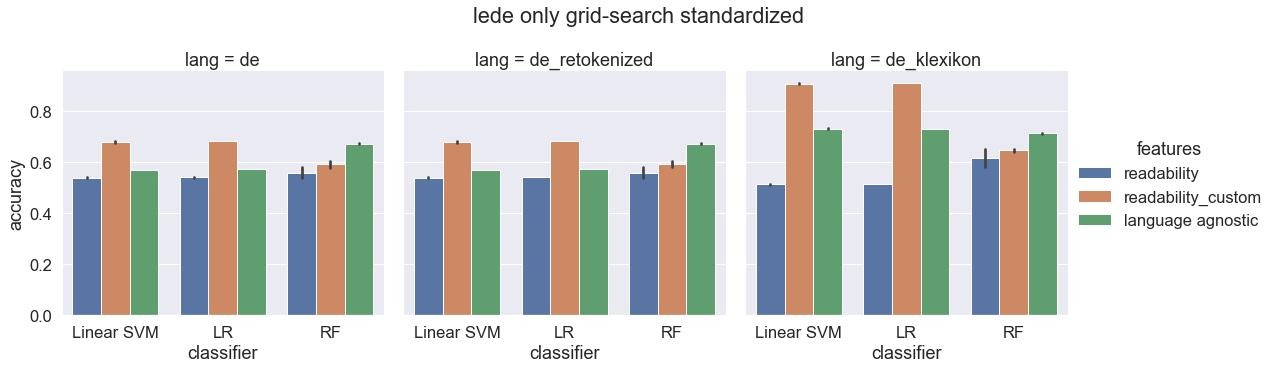

In [35]:
data_ = multi_results_df[multi_results_df['features'].isin(['readability', 'readability_custom', 'language agnostic'])]
data_ = data_[data_['lang'].isin(['de', 'de_retokenized', 'de_klexikon'])]

g = sns.catplot(data = data_, hue = 'features', y = score_metric, x = 'classifier', col="lang",
                kind="bar", col_wrap=3, col_order=['de', 'de_retokenized', 'de_klexikon']);
g.fig.subplots_adjust(top=0.8)

lede_label = 'lede only' if lede_flag else 'non-lede'
title = '%s %s %s' %(lede_label, gs, preprocessed)

g.fig.suptitle(title)
# g.savefig("../plots/%s_klexikon.png" %title) 

In [36]:
data_ = multi_results_df[multi_results_df['features'].isin(['readability', 'readability_custom', 'language agnostic'])]
# data_ = data_[data_['classifier'] == 'RF']
data_ = data_[~data_['lang'].isin(['de_klexikon', 'de_retokenized'])]

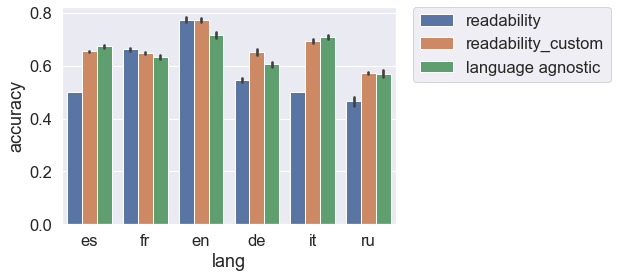

In [37]:
sns.barplot(data = data_, x = 'lang', y = 'accuracy', hue = 'features')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0.98, 'grid-search standardized')

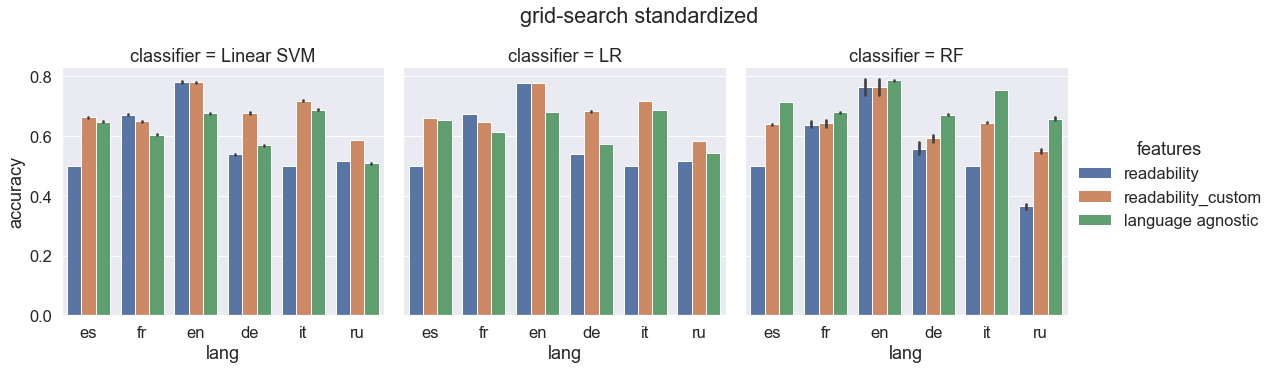

In [38]:
data_ = multi_results_df[multi_results_df['features'].isin(['readability', 'readability_custom', 'language agnostic'])]
# data_ = data_[data_['classifier'] == 'RF']
data_ = data_[~data_['lang'].isin(['de_klexikon', 'de_retokenized'])]
g = sns.catplot(data = data_, hue = 'features', y = score_metric, x = 'lang', col= 'classifier',
                kind="bar", col_wrap=3);
g.fig.subplots_adjust(top=0.81)

lede_label = 'lede only' if lede_flag else 'non-lede'
title = '%s %s' %(gs, preprocessed)

g.fig.suptitle(title)

In [39]:
for lang in langs:
    data_ = multi_results_df[multi_results_df['lang'] == lang]
    print('mean %s:' %score_metric)
    print(data_.groupby(['lang', 'features', 'classifier']).mean()[score_metric].unstack().round(2))
    print()
    print('%s std:' %score_metric)
    print(data_.groupby(['lang', 'features', 'classifier']).std()[score_metric].unstack().round(4))
    print()

mean accuracy:
classifier                 LR  Linear SVM    RF
lang features                                  
es   language agnostic   0.65        0.65  0.72
     readability         0.50        0.50  0.50
     readability_custom  0.66        0.66  0.64

accuracy std:
classifier                   LR  Linear SVM      RF
lang features                                      
es   language agnostic   0.0002      0.0021  0.0014
     readability         0.0000      0.0000  0.0000
     readability_custom  0.0001      0.0041  0.0065

mean accuracy:
classifier                 LR  Linear SVM    RF
lang features                                  
fr   language agnostic   0.61        0.61  0.68
     readability         0.68        0.67  0.64
     readability_custom  0.65        0.65  0.64

accuracy std:
classifier                   LR  Linear SVM      RF
lang features                                      
fr   language agnostic   0.0003      0.0007  0.0017
     readability         0.0001      0.0046

In [40]:
data = pd.DataFrame(multi_results_df.groupby(['lang', 'features',
                    'classifier']).mean()[score_metric].unstack().round(3))
std = pd.DataFrame(multi_results_df.groupby(['lang', 'features',
                    'classifier']).std()[score_metric].unstack().round(3))

In [41]:
for col in std.columns:
    std[col] = ' ± ' + std[col].astype(str)

In [42]:
data = data.astype(str) + std.astype(str)
data

classifier                                    LR     Linear SVM             RF
lang           features                                                       
de             language agnostic     0.572 ± 0.0  0.569 ± 0.002  0.672 ± 0.004
               readability          0.54 ± 0.001  0.539 ± 0.002  0.558 ± 0.056
               readability_custom  0.683 ± 0.002  0.678 ± 0.008  0.592 ± 0.034
de_klexikon    language agnostic     0.728 ± 0.0  0.731 ± 0.003  0.713 ± 0.006
               readability         0.514 ± 0.001  0.512 ± 0.003  0.617 ± 0.095
               readability_custom     0.91 ± 0.0  0.907 ± 0.006  0.646 ± 0.015
de_retokenized language agnostic     0.572 ± 0.0  0.569 ± 0.002  0.672 ± 0.004
               readability          0.54 ± 0.001  0.539 ± 0.002  0.558 ± 0.056
               readability_custom  0.683 ± 0.002  0.678 ± 0.008  0.592 ± 0.034
en             language agnostic     0.682 ± 0.0  0.676 ± 0.001  0.787 ± 0.004
               readability           0.777 ± 0.0  0.783 ± 0.008  0.764 ± 0.066
               readability_custom    0.777 ± 0.0   0.78 ± 0.004  0.763 ± 0.066
es             language agnostic     0.655 ± 0.0  0.649 ± 0.002  0.715 ± 0.001
               readability             0.5 ± 0.0      0.5 ± 0.0      0.5 ± 0.0
               readability_custom    0.662 ± 0.0  0.664 ± 0.004  0.639 ± 0.006
fr             language agnostic     0.613 ± 0.0  0.606 ± 0.001   0.68 ± 0.002
               readability           0.675 ± 0.0  0.672 ± 0.005  0.639 ± 0.027
               readability_custom    0.648 ± 0.0   0.65 ± 0.004  0.643 ± 0.032
it             language agnostic     0.687 ± 0.0  0.689 ± 0.003  0.754 ± 0.003
               readability             0.5 ± 0.0      0.5 ± 0.0      0.5 ± 0.0
               readability_custom    0.719 ± 0.0  0.719 ± 0.001  0.646 ± 0.004
ru             language agnostic     0.543 ± 0.0  0.509 ± 0.004  0.658 ± 0.012
               readability           0.516 ± 0.0    0.516 ± 0.0  0.365 ± 0.021
               readability_custom    0.585 ± 0.0  0.587 ± 0.003  0.549 ± 0.015

In [44]:
data.to_csv('../tables/gridsearch_multilingual_summary.csv', index = 'False', sep = '\t')